## HDAT 9910 Capstone


Research Question 1: Mortality Prediction in ICU 

Task: The task is to build a predictive algorithm using the techniques we learned in this course. 

Objective: To assess the role of machine learning algorithms for predicting mortality by using the MIMIC-III dataset. 

Question: Is it possible to accurately predict mortality based on data from the first 24 hours in ICU?   

Study Population: MIMIC-III dataset 

#### Load packages


In [ ]:
import numpy as np
import pandas as pd
import warnings
import os
import concurrent.futures
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)


#### Load in the preprocessed MIMIC-III Dataset

In [2]:
df = pd.read_csv('/Users\lukac\OneDrive\Desktop\HDAT-9910-Capstone/df_24Hrs.csv')

In [3]:
# Check the balance of the target variable
total_icu_stays = df['icustay_id'].nunique()
survivors = df.loc[df['mortality'] == 0, 'icustay_id'].nunique()
non_survivors = df.loc[df['mortality'] == 1, 'icustay_id'].nunique()

print(f"Number of ICU stays: {total_icu_stays}")
print(f"Number of survivors: {survivors}")
print(f"Number of non-survivors: {non_survivors}")

mortality_rate = (non_survivors / total_icu_stays) * 100
print(f"Mortality: {mortality_rate:.1f}%")

Number of ICU stays: 61533
Number of survivors: 37342
Number of non-survivors: 24192
Mortality: 39.3%


In [4]:
# Drop rows with any missing values
df.dropna(inplace=True)

### Model selection and training

In [5]:
from sklearn.model_selection import train_test_split

#Split the data into features and target variable
X = df.drop('mortality', axis=1)
y = df['mortality']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
from sklearn.preprocessing import StandardScaler

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Logistic Regression

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Hyperparameter tuning with GridSearchCV
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), parameters, cv=5)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Making predictions with the best model
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")


Accuracy: 0.72
Precision: 0.70
Recall: 0.66
ROC-AUC: 0.80


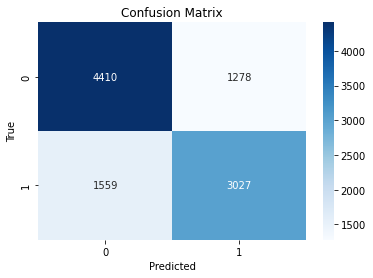

In [13]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Fit the model
forest = RandomForestClassifier()
forest.fit(X_train_scaled, y_train)

# Hyperperameter tuning
# Get important features
importances = forest.feature_importances_

# Select features based on importance
indices = np.argsort(importances)[::-1]

# Select a subset of the most important features
X_train_forest = X_train_scaled[:, indices[:80]]
X_test_forest = X_test_scaled[:, indices[:80]]

# Train a new model on the reduced set of features
forest.fit(X_train_forest, y_train)

In [ ]:
# Making predictions
y_pred = forest.predict(X_test_forest)
y_proba = forest.predict_proba(X_test_forest)[:, 1] 

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Print out the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")


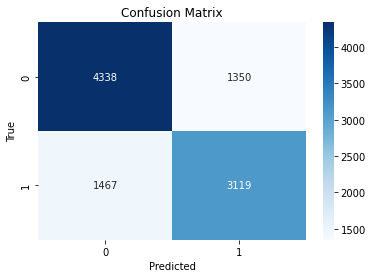

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Display a confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Gradient boosting machine

In [ ]:
!pip install xgboost


In [ ]:
from xgboost import XGBClassifier

# Initialise the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
xgb_roc_auc = roc_auc_score(y_test, y_proba_xgb)

# Print out the metrics
print(f"ROC-AUC Score: {roc_auc:.2f}")


### Neural networks

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Initialise the model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

from tensorflow.keras.callbacks import EarlyStopping
# Hyperperameter tuning
early_stopping = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
nn_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
_, roc_auc_nn = nn_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Neural Network ROC-AUC Score: {roc_auc_nn:.2f}")

Epoch 1/10
1028/1028 [==============================] - 4s 2ms/step - loss: 0.5575 - auc: 0.7872 - val_loss: 0.5392 - val_auc: 0.8019
Epoch 2/10
1028/1028 [==============================] - 3s 3ms/step - loss: 0.5321 - auc: 0.8089 - val_loss: 0.5289 - val_auc: 0.8082
Epoch 3/10
1028/1028 [==============================] - 2s 2ms/step - loss: 0.5197 - auc: 0.8177 - val_loss: 0.5271 - val_auc: 0.8107
Epoch 4/10
1028/1028 [==============================] - 2s 2ms/step - loss: 0.5113 - auc: 0.8246 - val_loss: 0.5314 - val_auc: 0.8103
Epoch 5/10
1028/1028 [==============================] - 2s 2ms/step - loss: 0.5042 - auc: 0.8297 - val_loss: 0.5324 - val_auc: 0.8120
Epoch 6/10
1028/1028 [==============================] - 2s 2ms/step - loss: 0.4970 - auc: 0.8354 - val_loss: 0.5302 - val_auc: 0.8117
Epoch 7/10
1028/1028 [==============================] - 3s 3ms/step - loss: 0.4900 - auc: 0.8400 - val_loss: 0.5345 - val_auc: 0.8088
Epoch 8/10
1028/1028 [==============================] - 3s 3ms